## Introduction to the automated analysis of EEG quality

This notebook will introduce you to the challenge by going through the data and working towards a first very simple model.

## Loading the data

In [2]:
## First let's load the training data
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import pandas as pd

ROOT_PATH = Path("train/")
training_data = [(np.load(ROOT_PATH / f"data_{i}.npy"),np.load(ROOT_PATH / f"target_{i}.npy")) for i in range(4)]


We expect to have five channels and one label per channel for each two seconds of data.
Let's have a look at the data duration and shape

In [3]:
# Let's have a look at the data duration
for i,(data,target) in enumerate(training_data):
    print()
    print(f"Recording {i}")
    print("Data shape", data.shape,target.shape)
    print("Data duration:", data.shape[1]/250)
    print("Labels duration",target.shape[1] * 2)
    



Recording 0
Data shape (5, 7712740) (5, 15425)
Data duration: 30850.96
Labels duration 30850

Recording 1
Data shape (5, 5232364) (5, 10464)
Data duration: 20929.456
Labels duration 20928

Recording 2
Data shape (5, 6421756) (5, 12843)
Data duration: 25687.024
Labels duration 25686

Recording 3
Data shape (5, 6809761) (5, 13619)
Data duration: 27239.044
Labels duration 27238


## Plotting the EEG and labels

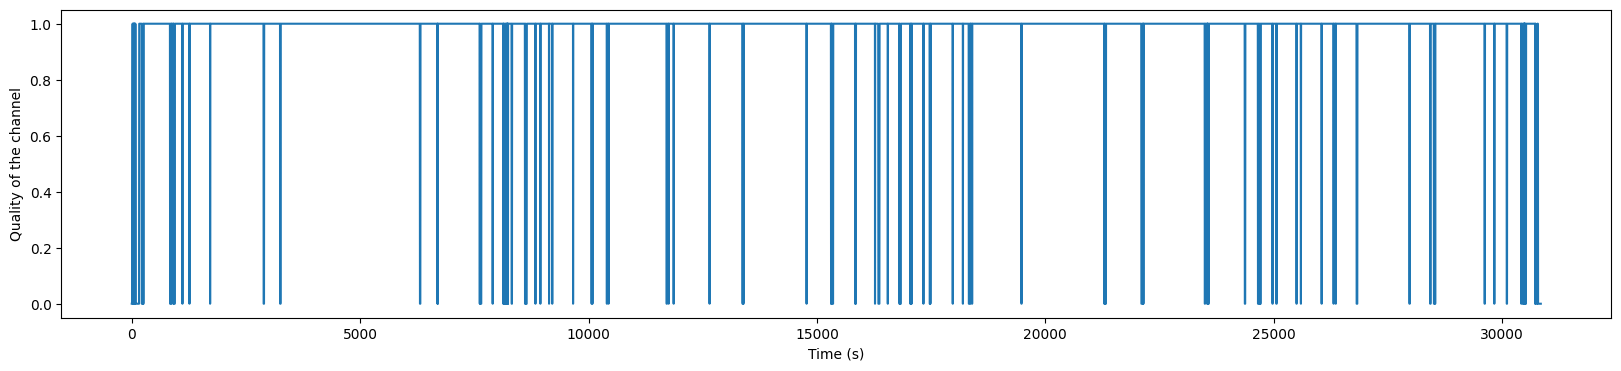

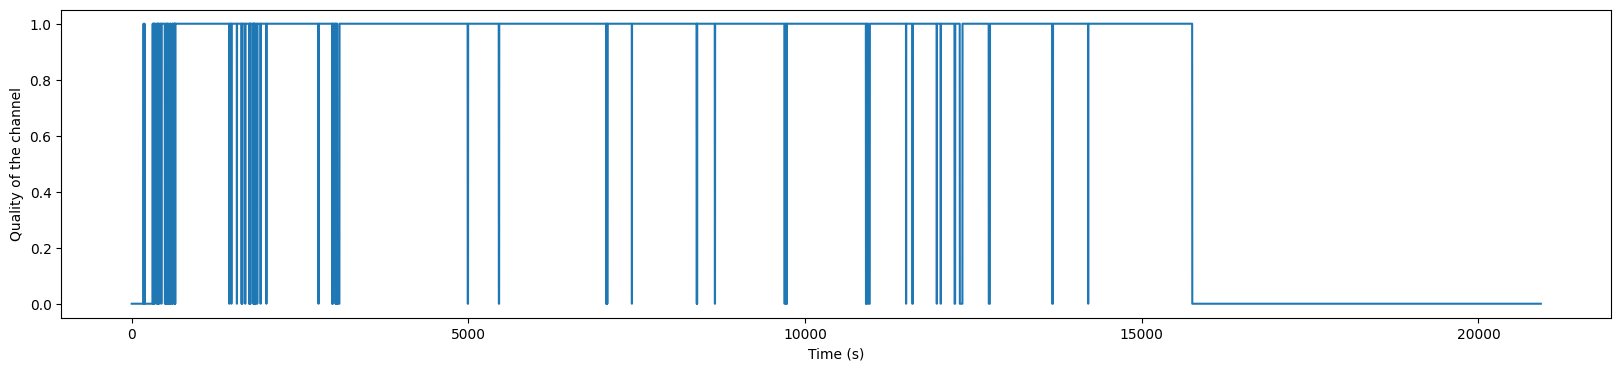

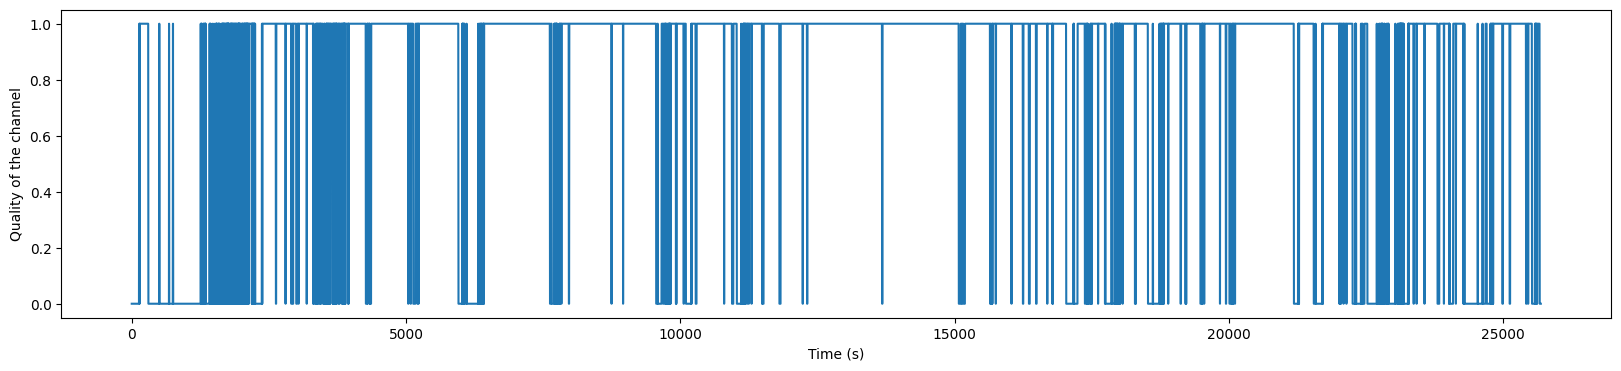

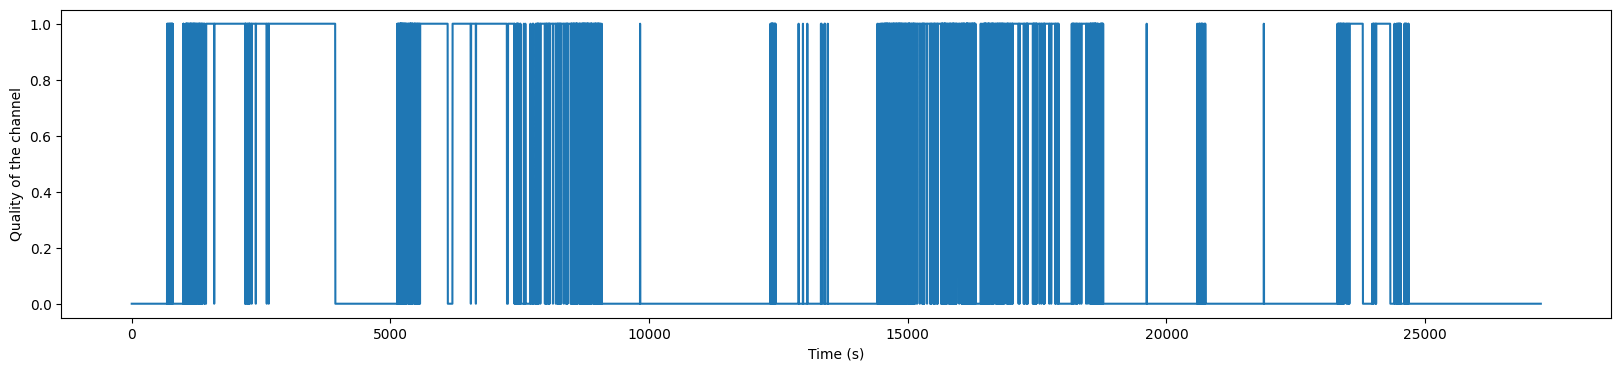

In [4]:

# Let's plot the target from the first channel for all the recordings
for i,(data,target) in enumerate(training_data):
    plt.figure(figsize=(20,4))
    plt.plot(np.arange(0,len(target[0])) * 2, target[0])
    plt.ylabel('Quality of the channel')
    plt.xlabel("Time (s)")
    plt.show()

In [5]:
## We improve a bit the plotting code to plot span of data and corresponding label

def plot_predictions_and_signal(
    target,
    data,
    start_time: float,
    stop_time: float,
    data_sampling_rate: int = 250,
    target_duration: int = 2,
    channel_to_plot: int = 0,
):
    """
    
    
    """

    # Calculate the start and stop indices for the signal
    start_idx_signal = int(start_time * data_sampling_rate)
    stop_idx_signal = int(stop_time * data_sampling_rate)

    # Calculate the start and stop indices for the labels
    start_idx_label = int(start_time / target_duration)
    stop_idx_label = int(stop_time / target_duration)

    # Slice the data and prediction probabilities
    sliced_signal = data[channel_to_plot, start_idx_signal:stop_idx_signal]
    sliced_prediction_prob = (
        target[channel_to_plot, start_idx_label:stop_idx_label]
    )

    fig, ax = plt.subplots(2, 1, figsize=(20, 10))

    # Plot the sliced EEG signal
    ax[0].plot(np.arange(len(sliced_signal)) / data_sampling_rate, sliced_signal)
    ax[0].set_title("EEG signal")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Amplitude")

    ax[1].plot(
        np.arange(len(sliced_prediction_prob)) * target_duration,
        sliced_prediction_prob,
    )
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Probs")

    plt.show()



0.5086964831804281


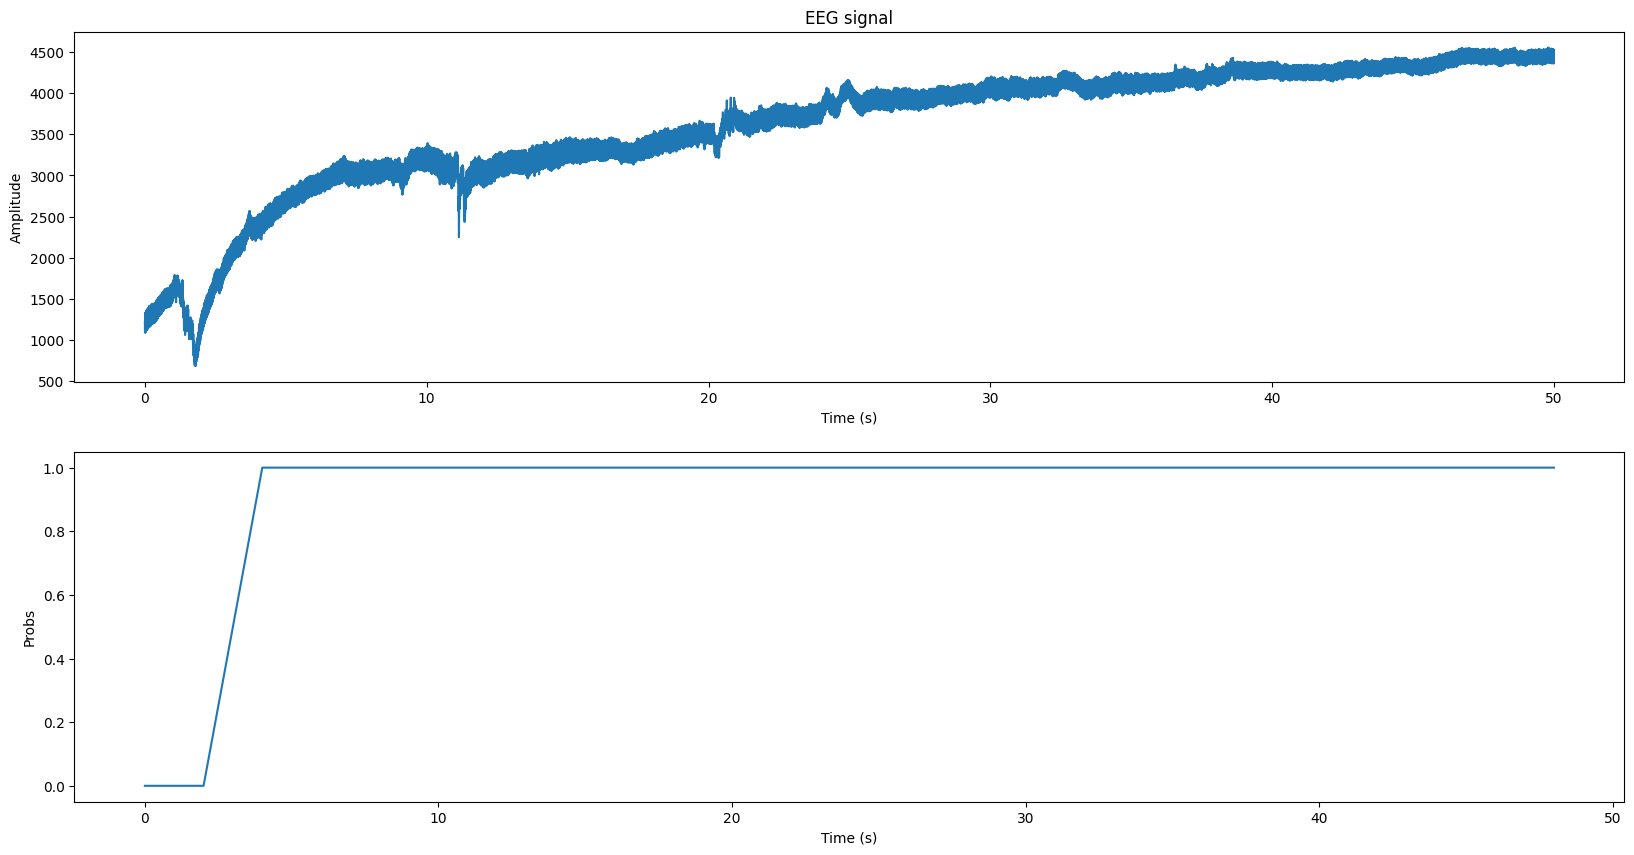

In [6]:
# We first plot the data and target from the first recording
# We see that there is a big DC component 
target = np.load("train/target_1.npy")
data = np.load("train/data_1.npy")
print(np.mean(target))
plot_predictions_and_signal(target,data,start_time = 300, stop_time = 350, data_sampling_rate = 250,target_duration = 2, channel_to_plot = 2)

To remove the DC component and high frequency component we apply a band-pass filter

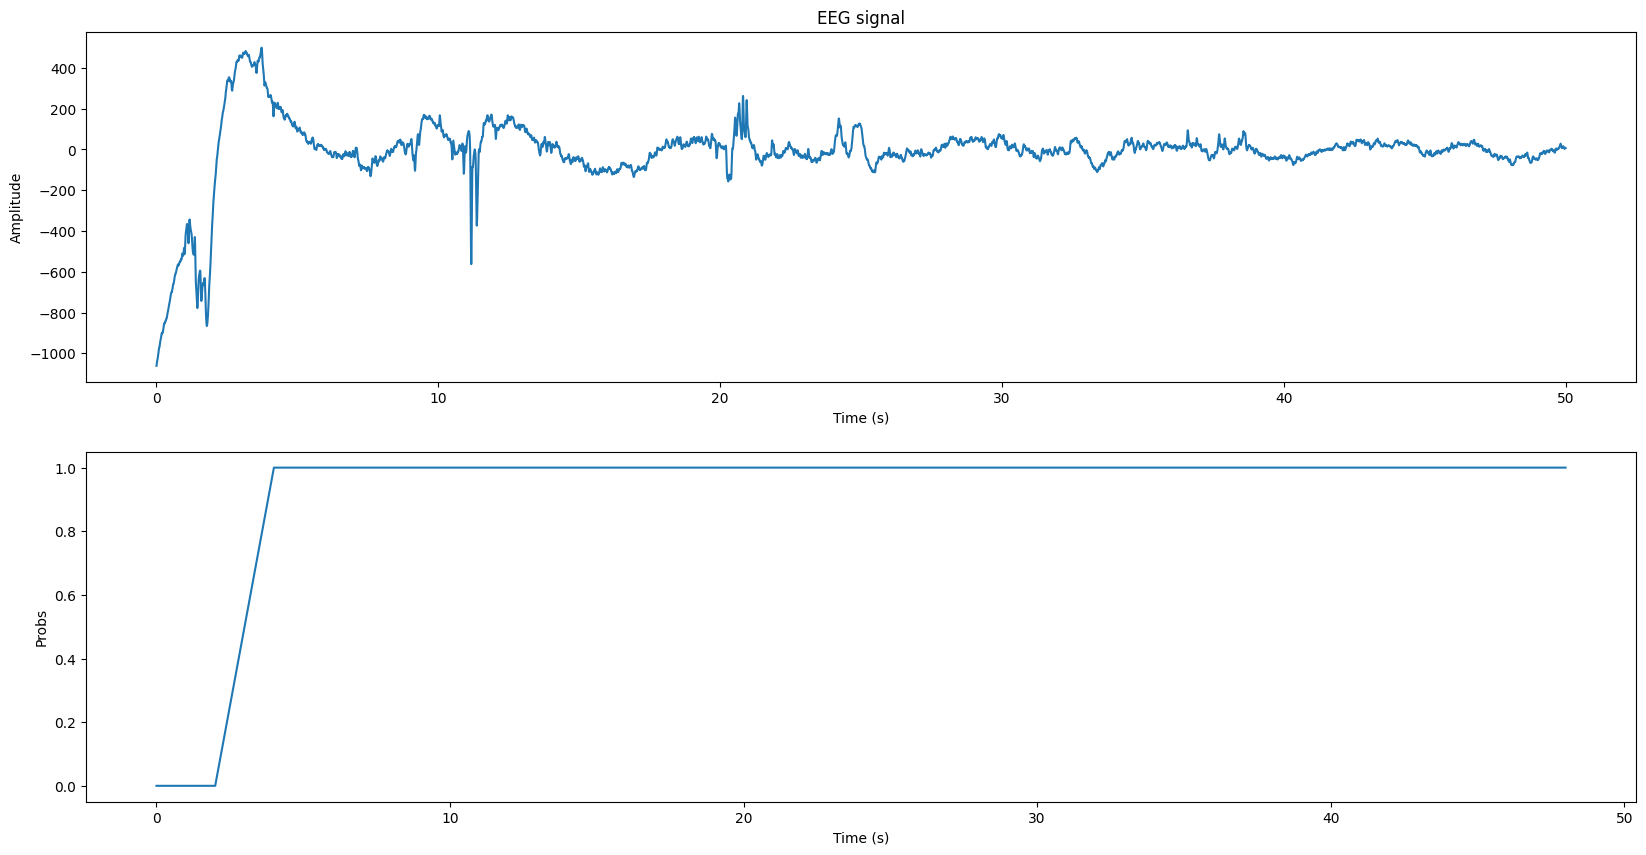

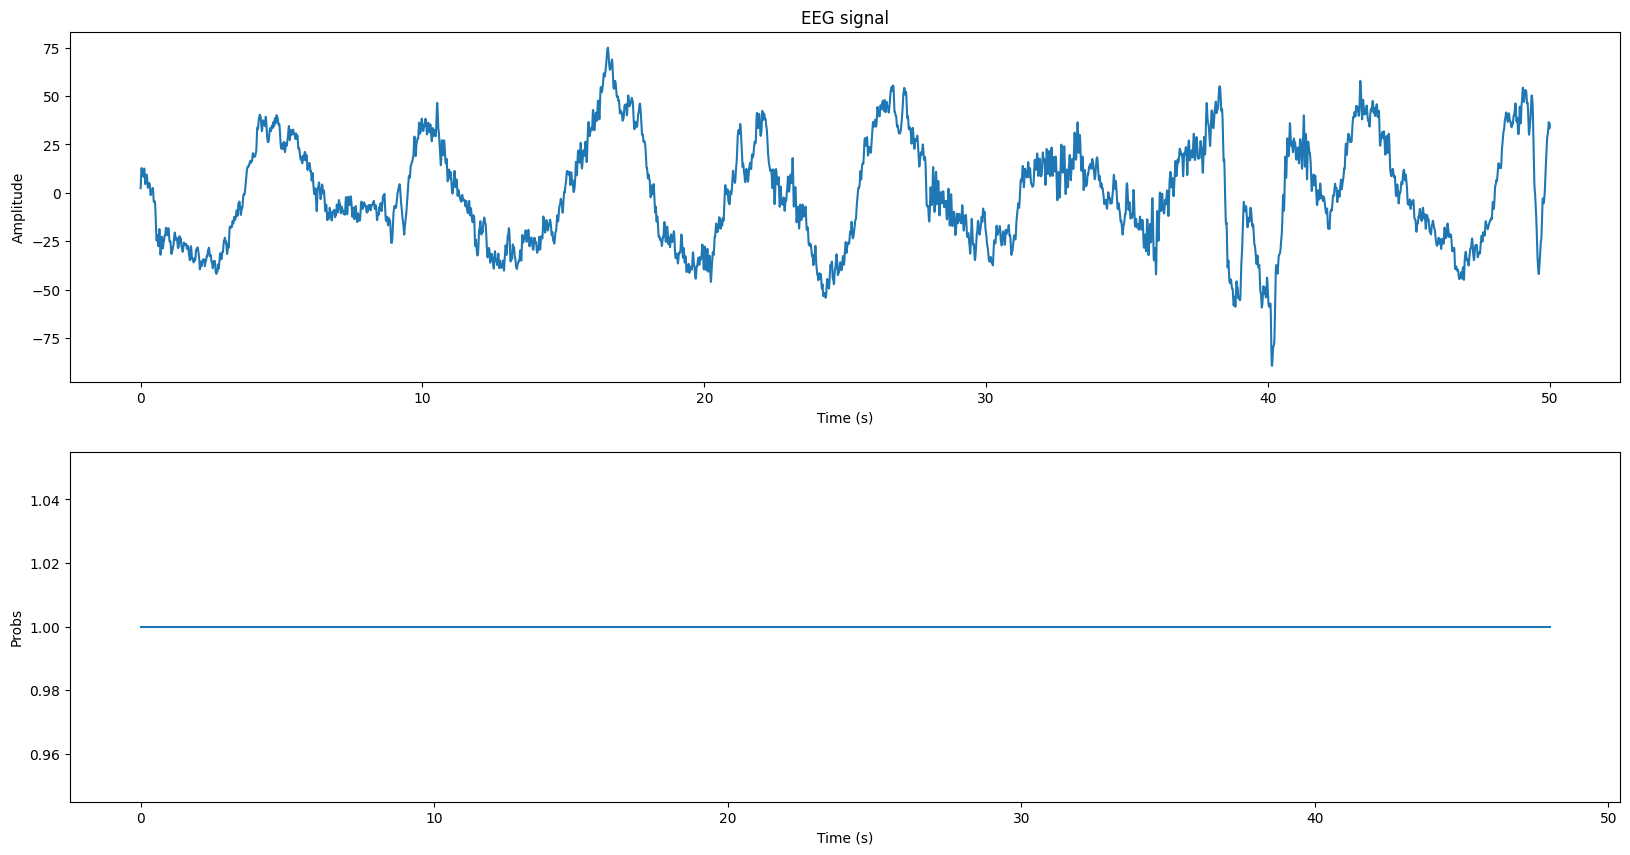

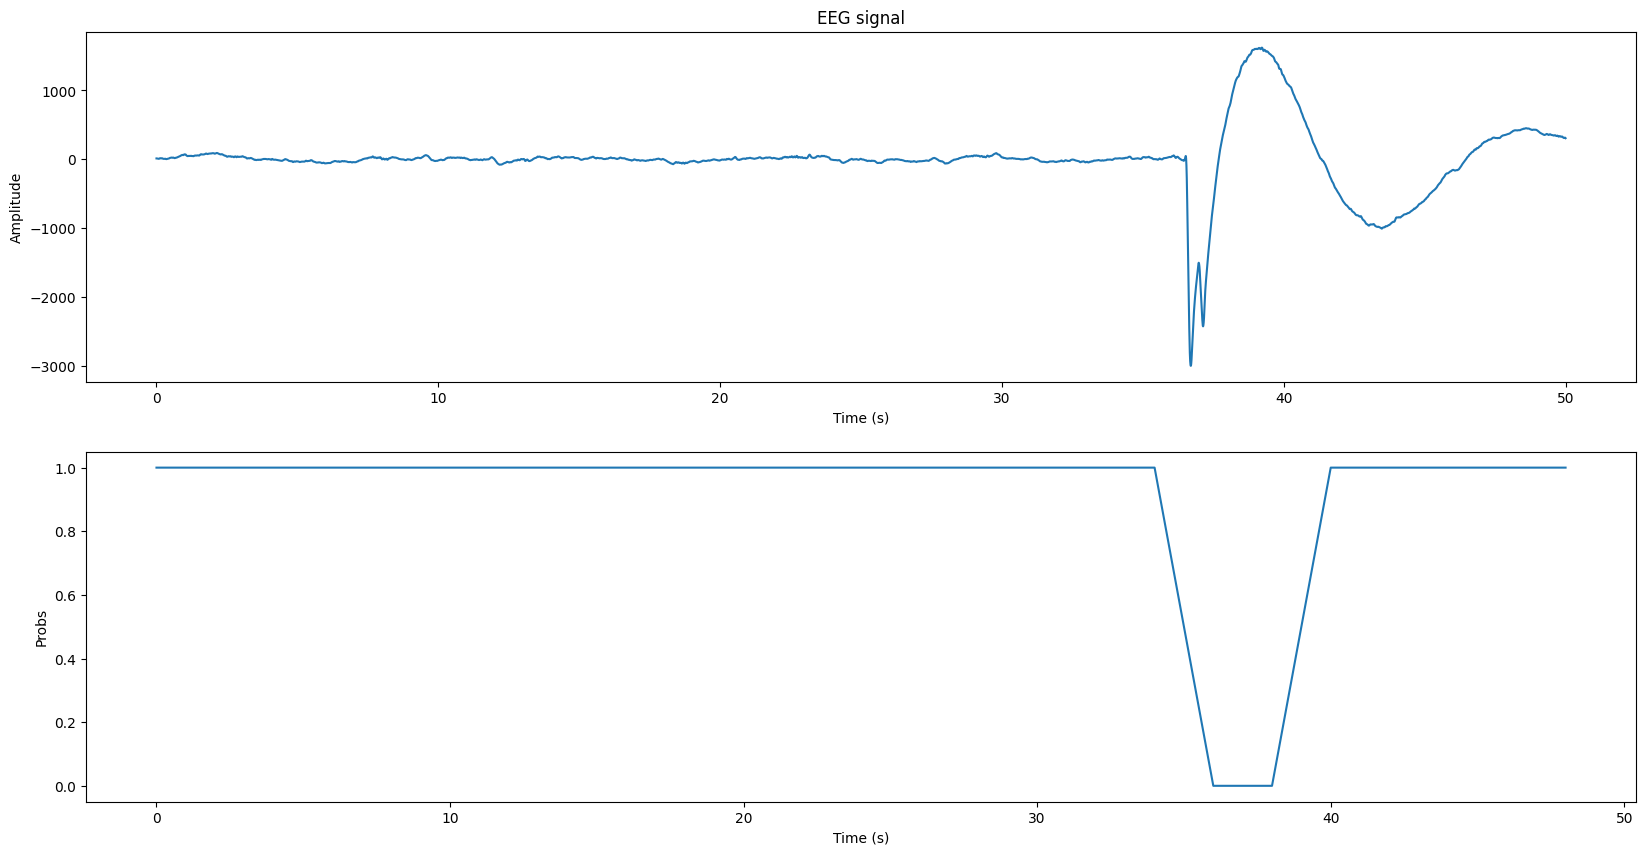

In [7]:
# Let's filter the signal to improve the visualisation

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

filtered_data = butter_bandpass_filter(data,0.1,18,250,4)
# We plot three spans and associated labels from the recording

plot_predictions_and_signal(target,filtered_data,start_time = 300, stop_time = 350, data_sampling_rate = 250,target_duration = 2 ,channel_to_plot = 2)
plot_predictions_and_signal(target,filtered_data,start_time = 1000, stop_time = 1050, data_sampling_rate = 250,target_duration = 2 ,channel_to_plot = 2)
plot_predictions_and_signal(target,filtered_data,start_time = 3000, stop_time = 3050, data_sampling_rate = 250,target_duration = 2 ,channel_to_plot = 2)

We see that some of the high amplitude is classified as bad quality, we could use that to build a first simple model

## Exploring the statistics of the good and bad quality EEG

In [8]:
# First we need to get the point that maps to a label

def reshape_array_into_windows(x, sample_rate, window_duration_in_seconds):
    """
    Reshape the data into an array of shape (C, T, window) where 'window' contains
    the points corresponding to 'window_duration' seconds of data.

    Parameters:
    x (numpy array): The input data array.
    sample_rate (int): The number of samples per second.
    window_duration_in_seconds (float): The duration of each window in seconds.

    Returns:
    reshaped_x (numpy array): The reshaped array with shape (C, T, window).
    """
    # Calculate the number of samples in one window
    window_size = int(window_duration_in_seconds * sample_rate)
    
    # Ensure the total length of x is a multiple of window_size
    total_samples = x.shape[-1]
    if total_samples % window_size != 0:
        # Truncate or pad x to make it divisible by window_size
        x = x[..., :total_samples - (total_samples % window_size)]
    # Reshape x into (C, T, window)
    reshaped_x = x.reshape(x.shape[0], -1, window_size)

    return reshaped_x


In [9]:
reshaped_array = reshape_array_into_windows(filtered_data,250,2)
# Quick unit test to ensure the reshape worked as expected
assert np.array_equal(reshaped_array[0,0],filtered_data[0,:500])
assert np.array_equal(reshaped_array[0,1],filtered_data[0,500:1000])
assert np.array_equal(reshaped_array[0,10],filtered_data[0,5000:5500])
assert np.array_equal(reshaped_array[1,1],filtered_data[1,500:1000])




In [10]:
# 10464 windows of 2 seconds each (250 freq x 2) for 5 channels
reshaped_array.shape

(5, 10464, 500)

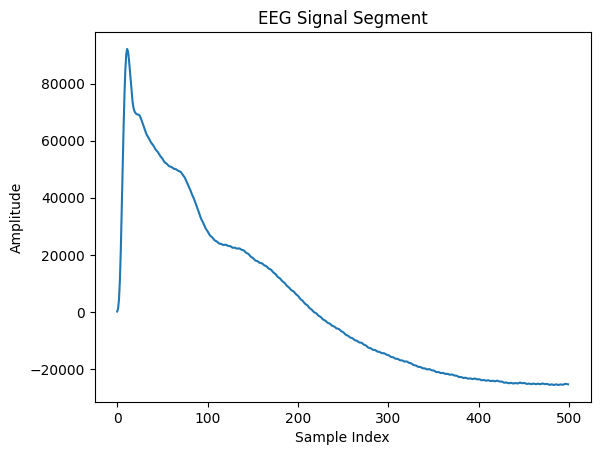

In [11]:
reshaped_array[0][0]
plt.plot(reshaped_array[0][0])
plt.title("EEG Signal Segment")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

In [12]:
# We can now compute the mean, max and stdev over each 2 seconds segment to try to build features
amplitude = (np.max(reshaped_array,-1) - np.min(reshaped_array,-1)).reshape(-1)
targets_flatten = target[..., :len(reshaped_array[0])].reshape(-1)

In [13]:
print(amplitude.shape)
print(targets_flatten.shape)

(52320,)
(52320,)


In [14]:
data = pd.DataFrame({"amplitude":amplitude,"target":targets_flatten})

In [15]:
# Amplitude and target
data.shape

(52320, 2)

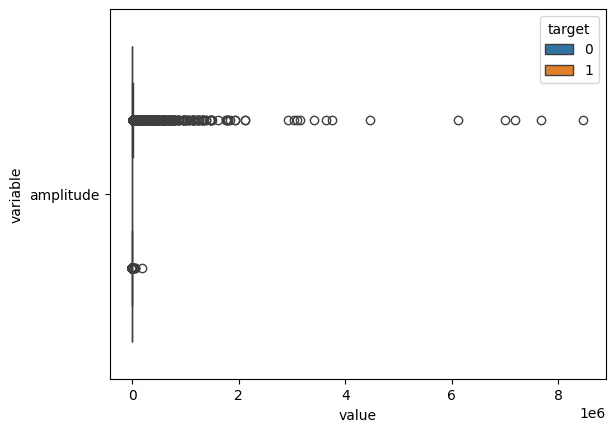

In [16]:
melted_data = pd.melt(data, value_vars = ["amplitude"],id_vars = "target")
sns.boxplot(melted_data,y = "variable", x = "value",hue = "target")
plt.show()

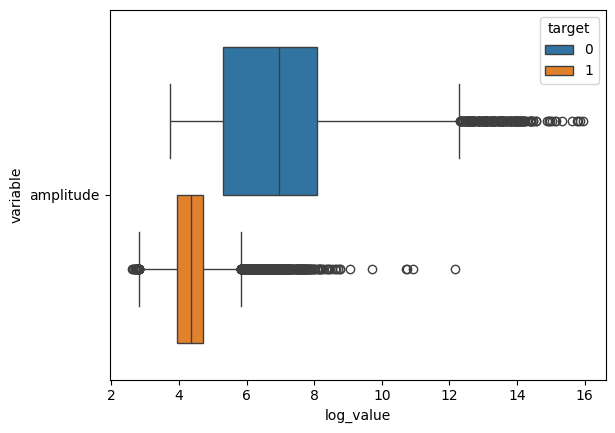

In [17]:
# We need to take the log to visualize the data better
# The goof (target = 1) and bad (target = 0) data seems to be relatively separable based on our three features
melted_data["log_value"] = np.abs(np.log(melted_data.value + 1))
sns.boxplot(melted_data,y = "variable", x = "log_value",hue = "target")
plt.show()

In [18]:
def calculate_snr(signal):
    """
    Calculate the Signal-to-Noise Ratio (SNR) for a given signal.
    
    Args:
        signal (array-like): The EEG signal data.
        
    Returns:
        float: The calculated SNR.
    """
    # Calculate power of the signal (mean of squared values)
    signal_power = np.mean(signal**2)
    
    # Estimate noise as the standard deviation (TODO: adjust this estimation method)
    noise_power = np.std(signal)**2  # Variance
    
    # Calculate SNR
    snr = signal_power / noise_power if noise_power != 0 else np.inf  # Avoid division by zero
    
    return snr

In [19]:
snr_data = []
for channel in range(reshaped_array.shape[0]):
    channel_snr = []
    for window in range(reshaped_array.shape[1]):
        snr = calculate_snr(reshaped_array[channel, window])
        channel_snr.append(snr)
    snr_data.append(channel_snr)
snr_data = np.array(snr_data)
print("SNR shape: ", snr_data.shape)

SNR shape:  (5, 10464)


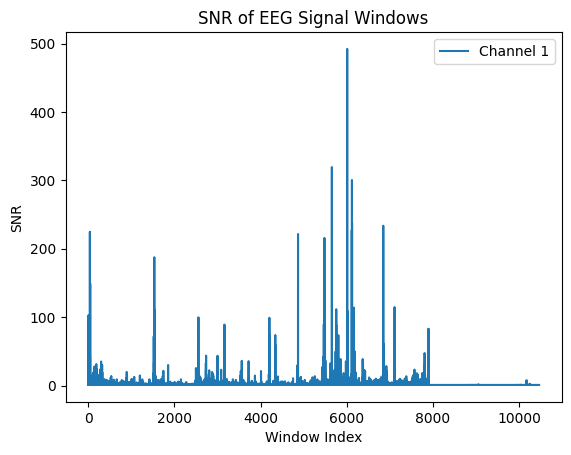

In [20]:
# Convert snr_data to a numpy array for easier manipulation
snr_data_array = np.array(snr_data)

# Plot the SNR data for each channel
plt.plot(snr_data_array[0], label=f'Channel 1')

plt.title('SNR of EEG Signal Windows')
plt.xlabel('Window Index')
plt.ylabel('SNR')
plt.legend()
plt.show()

In [33]:
from scipy.signal import welch

def calculate_psd(signal_window, fs=250, nperseg=500):
    """
    Calculate the Power Spectral Density (PSD) for different EEG bands for a given window.
    
    Args:
        signal_window (array-like): The EEG signal data for the window.
        fs (int): Sampling frequency of the signal.
        nperseg (int): Length of each segment for Welch's method.
        
    Returns:
        tuple: A tuple containing the power in different EEG bands (delta, theta, alpha, beta, gamma).
    """
    # Define EEG bands
    eeg_bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 12),
        'beta': (12, 30),
        'gamma': (30, 100)
    }
    
    # Calculate the PSD using Welch's method
    freqs, psd = welch(signal_window, fs, nperseg=nperseg)
    
    # Initialize a dictionary to store the power in each band
    band_power = {}
    
    for band, (low_freq, high_freq) in eeg_bands.items():
        # Find the indices corresponding to the frequency band
        idx_band = np.logical_and(freqs >= low_freq, freqs <= high_freq)
        
        # Calculate the average power in the band
        band_power[band] = np.mean(psd[idx_band])
    
    return (band_power['delta'], band_power['theta'], band_power['alpha'], band_power['beta'], band_power['gamma'])

# Example usage
signal_window = reshaped_array[0][0]  
delta, theta, alpha, beta, gamma = calculate_psd(signal_window)
print(f'Delta power: {delta}')
print(f'Theta power: {theta}')
print(f'Alpha power: {alpha}')
print(f'Beta power: {beta}')
print(f'Gamma power: {gamma}')

Delta power: 59183655.52893382
Theta power: 18861.127616300157
Alpha power: 1887.668502982037
Beta power: 128.62923373600134
Gamma power: 71.32807055116658


In [38]:
# Calculate PSD for all windows and channels
psd_data = []
for channel in range(reshaped_array.shape[0]):
    channel_psd = []
    for window in range(reshaped_array.shape[1]):
        delta, theta, alpha, beta, gamma = calculate_psd(reshaped_array[channel, window])
        channel_psd.append({
            'delta': delta,
            'theta': theta,
            'alpha': alpha,
            'beta': beta,
            'gamma': gamma
        })
    psd_data.append(channel_psd)

# Convert the PSD data to a DataFrame for easier plotting
psd_df = pd.DataFrame([
    {'channel': ch, 'window': win, **psd}
    for ch, channel_psd in enumerate(psd_data)
    for win, psd in enumerate(channel_psd)
])


In [41]:
print(psd_df.shape)
print(psd_df)


(52320, 7)
       channel  window         delta         theta          alpha  \
0            0       0  5.918366e+07  1.886113e+04    1887.668503   
1            0       1  1.981876e+07  1.781656e+06  284863.469799   
2            0       2  5.426548e+05  8.285500e+03    1075.391843   
3            0       3  1.681765e+05  2.486169e+02    1156.407637   
4            0       4  9.008690e+05  5.710697e+03    1446.716701   
...        ...     ...           ...           ...            ...   
52315        4   10459  5.571471e+02  3.261054e+02    1864.210723   
52316        4   10460  6.414296e+02  2.979842e+02    1834.424873   
52317        4   10461  6.532337e+02  4.540069e+02    2068.281691   
52318        4   10462  2.202069e+02  3.705190e+02    1570.363827   
52319        4   10463  3.858852e+02  1.890689e+02    1932.322590   

               beta         gamma  
0        128.629234     71.328071  
1      58660.122097     63.634922  
2         66.629834     46.917029  
3         57.163

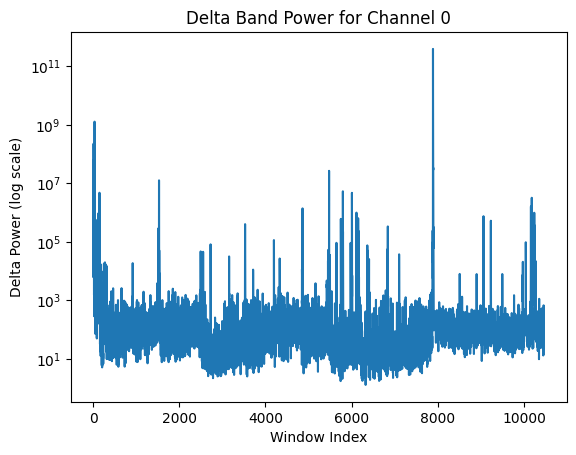

In [51]:
plt.plot(psd_df[psd_df['channel'] == 0]['delta'])
plt.yscale('log')
plt.title('Delta Band Power for Channel 0')
plt.xlabel('Window Index')
plt.ylabel('Delta Power (log scale)')
plt.show()

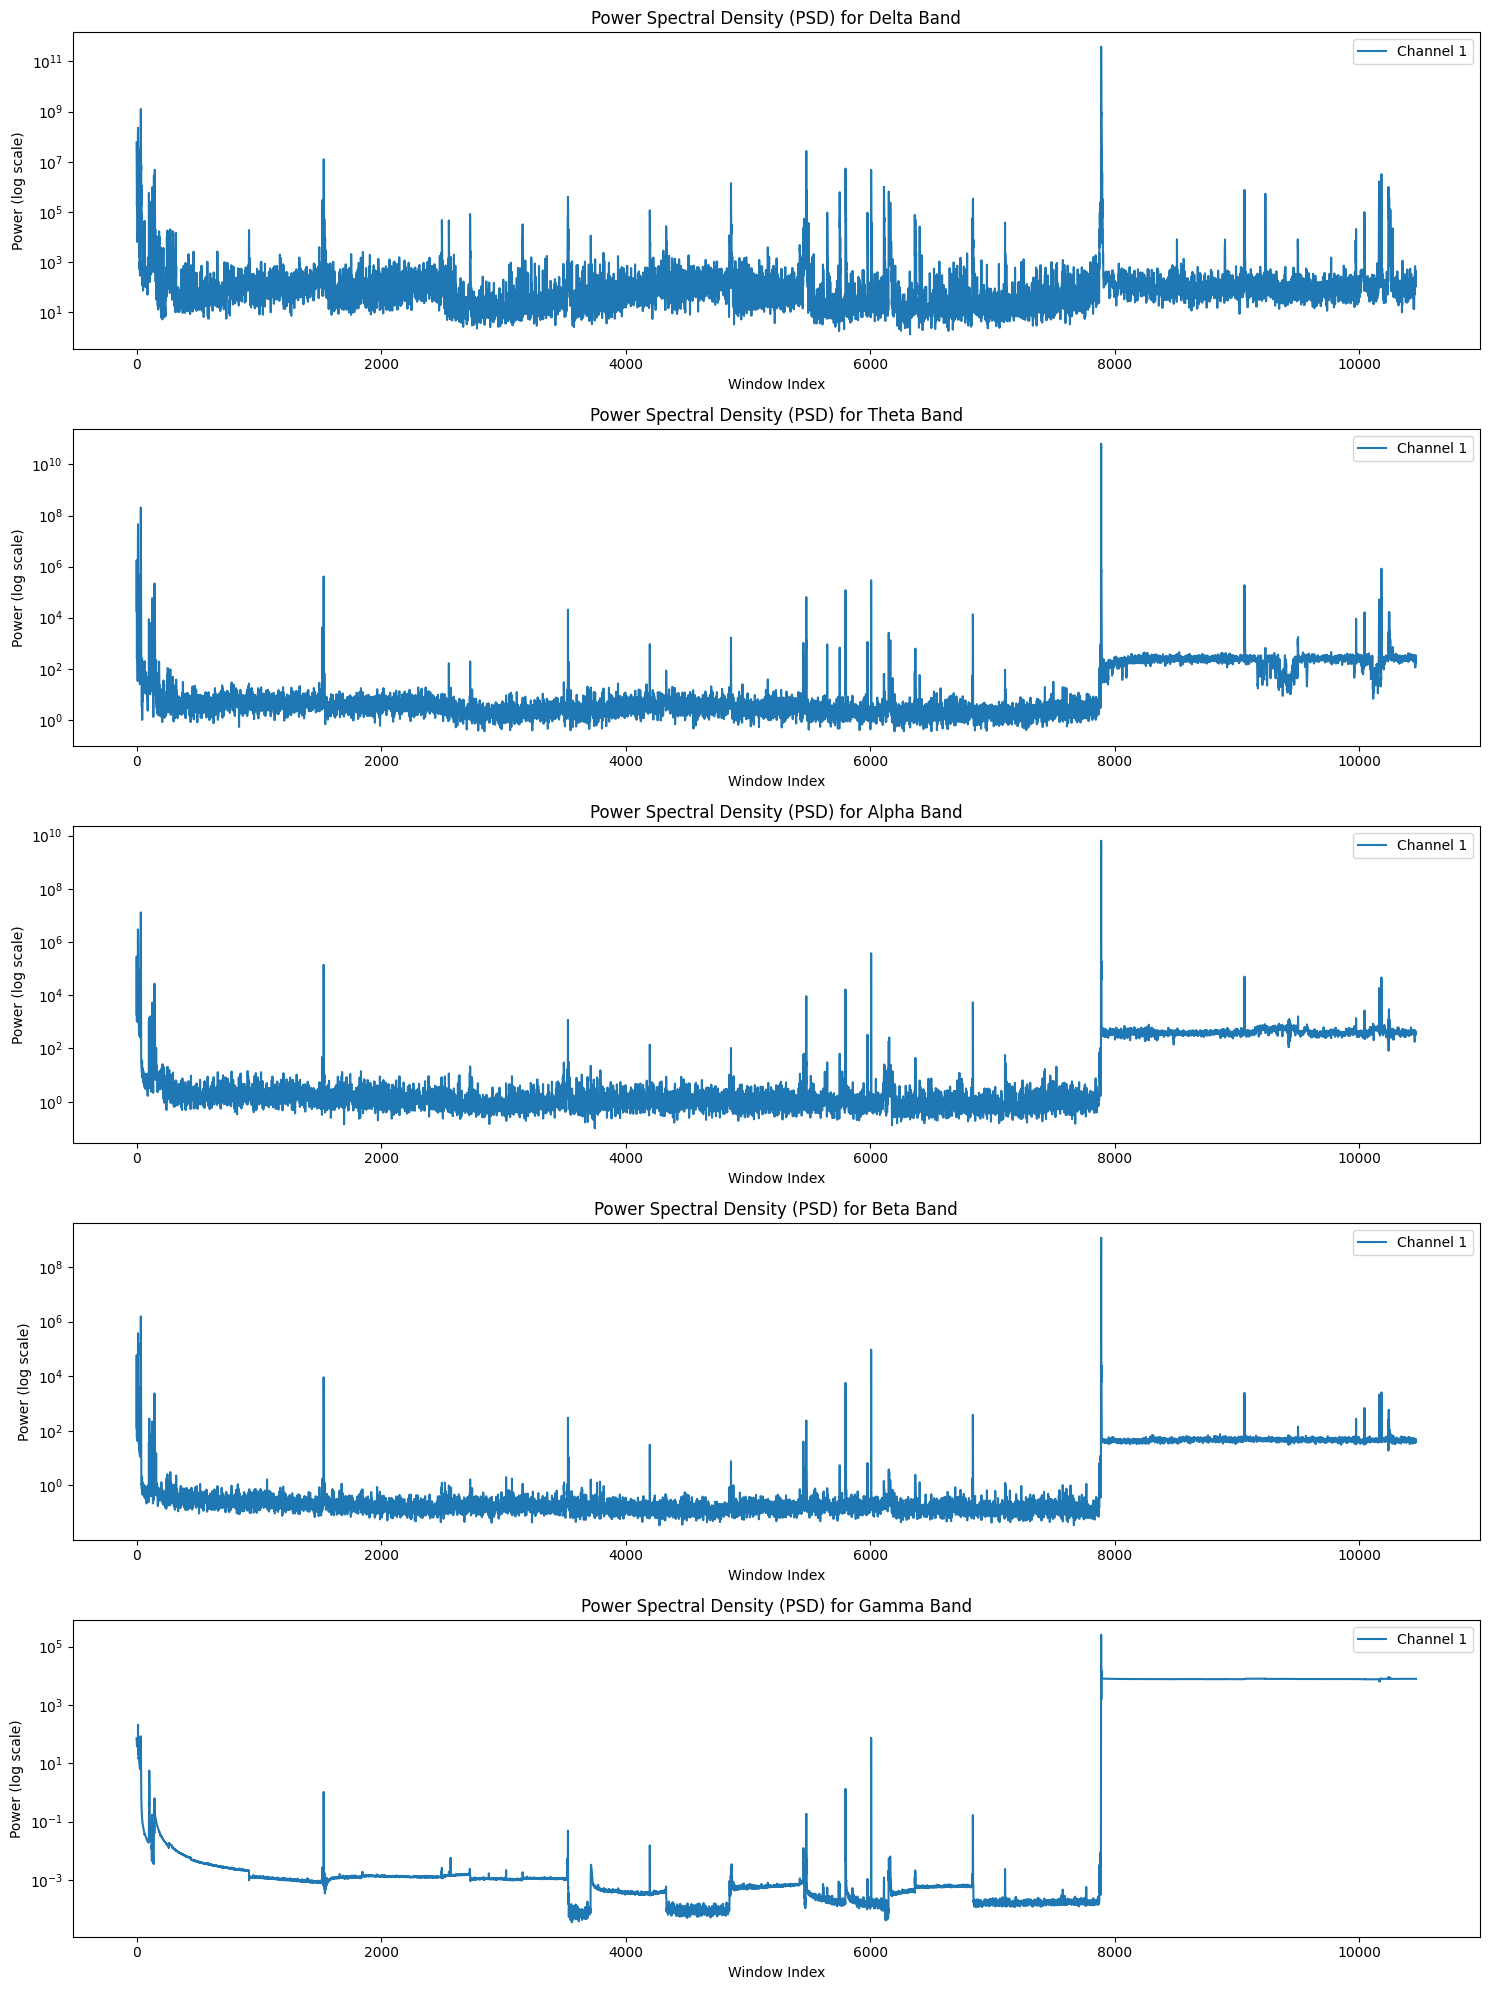

In [52]:
# Plot the PSD for each band separately for the first channel
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
plt.figure(figsize=(15, 20))

for i, band in enumerate(bands):
    plt.subplot(len(bands), 1, i + 1)
    plt.plot(psd_df[psd_df['channel'] == 0][band], label=f'Channel 1')  # x axis = 1, 2 ... 10464; y axis = power
    plt.title(f'Power Spectral Density (PSD) for {band.capitalize()} Band')
    plt.xlabel('Window Index')
    plt.yscale('log')
    plt.ylabel('Power (log scale)')
    plt.legend()

plt.tight_layout()
plt.show()

## Building a simple model based on our observation

In [22]:
# We first load and reshape all the data
all_data = []
all_targets = []
for (data,target) in training_data:
    filtered_data =  butter_bandpass_filter(data,0.1,18,250,4)
    reshaped_data = reshape_array_into_windows(filtered_data,250,2)
    targets_flatten = target[..., :len(reshaped_data[0])].reshape(-1)
    reshaped_data = reshaped_data.reshape((-1,reshaped_data.shape[-1]))
    all_data.append(reshaped_data)
    all_targets.append(targets_flatten)
all_data = np.concatenate(all_data)
all_targets = np.concatenate(all_targets)
assert all_data.shape[0] == all_targets.shape[0]


In [23]:
all_data.shape

(261755, 500)

In [53]:
# We can now compute the mean, max and stdev over each 2 seconds segment to try to build features
amplitude = (np.max(all_data, -1) - np.min(all_data, -1)).reshape(-1)
print("Amplitude shape: ", amplitude.shape)

# Calculate SNR for each window
snr_values = []
for window in range(all_data.shape[0]):
    snr = calculate_snr(all_data[window])
    snr_values.append(snr)

# Reshape snr_values to match the shape of amplitude
snr_values = np.array(snr_values).reshape(-1)
print("SNR shape: ", snr_values.shape)

# Calculate PSD for all windows
psd_data = []
for window in range(all_data.shape[0]):
    delta, theta, alpha, beta, gamma = calculate_psd(all_data[window])
    psd_data.append({
        'delta': delta,
        'theta': theta,
        'alpha': alpha,
        'beta': beta,
        'gamma': gamma
    })

# Convert the PSD data to a DataFrame for easier manipulation
psd_df = pd.DataFrame(psd_data)


Amplitude shape:  (261755,)
SNR shape:  (261755,)
PSD features shape:  (261755, 5)


In [58]:
psd_df.head()

,delta,theta,alpha,beta,gamma
0,4.032514e+06,114.030142,7.940112,2.609811,0.008536
1,4.983497e+05,128.333661,33.122320,2.414790,0.035935
2,8.755054e+04,40.080128,14.667690,1.164399,0.026535
3,3.427283e+04,86.046413,5.774292,1.155370,0.023585
4,2.541997e+04,28.083023,13.699743,2.510507,0.022308


In [59]:
training_data = pd.DataFrame({"amplitude": amplitude, 
                              "snr": snr_values, 
                              "delta": psd_df["delta"],
                              "theta": psd_df["theta"],
                              "alpha": psd_df["alpha"],
                              "beta": psd_df["beta"],
                              "gamma": psd_df["gamma"],
                              "target": all_targets})

In [62]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize the scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Standardize the features
X_train_standardized = standard_scaler.fit_transform(training_data)

# Normalize the features to have max value = 1
X_train_normalized = minmax_scaler.fit_transform(X_train_standardized)

# Convert back to DataFrame for consistency
X_train_normalized = pd.DataFrame(X_train_normalized, columns=training_data.columns)

print(X_train_normalized.head())

   amplitude           snr         delta         theta         alpha  \
0   0.002930  1.934406e-05  2.807797e-06  4.036856e-10  6.266154e-10   
1   0.000768  3.140932e-03  3.469955e-07  4.543443e-10  2.619234e-09   
2   0.000414  2.994031e-03  6.096036e-08  1.417775e-10  1.158956e-09   
3   0.000223  1.182807e-02  2.386365e-08  3.045759e-10  4.552383e-10   
4   0.000241  1.092659e-07  1.769949e-08  9.928747e-11  1.082364e-09   

           beta         gamma  target  
0  1.041900e-09  1.630796e-08     0.0  
1  9.637111e-10  6.870944e-08     0.0  
2  4.623950e-10  5.073171e-08     0.0  
3  4.587751e-10  4.509072e-08     0.0  
4  1.002087e-09  4.264752e-08     0.0  


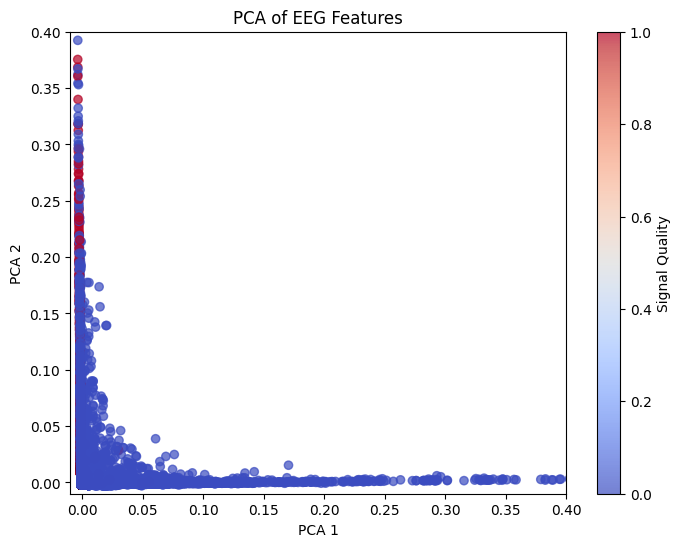

In [65]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Features and target
X = X_train_normalized.drop("target", axis=1)
y = X_train_normalized["target"]

# PCA for 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Scatter plot of the PCA components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="coolwarm", alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of EEG Features')
plt.colorbar(label='Signal Quality')
plt.xlim(-0.01, 0.4)
plt.ylim(-0.01, 0.4)
plt.show()

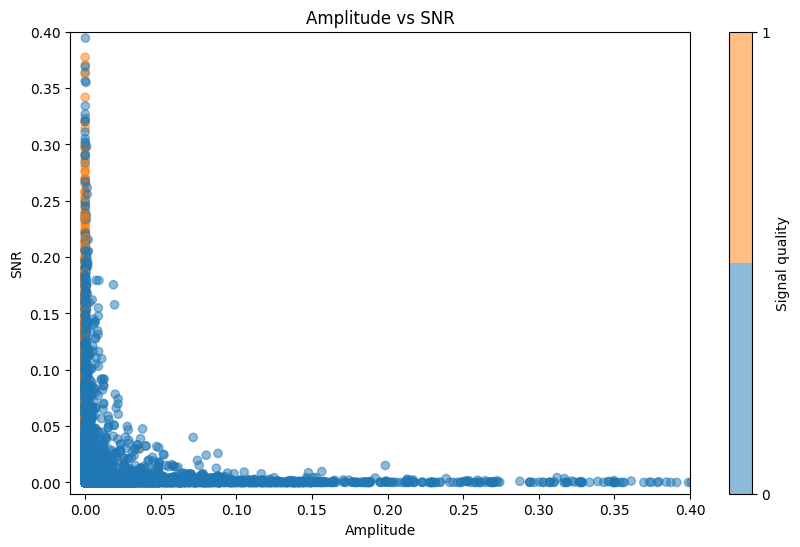

In [26]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['#1f77b4', '#ff7f0e'])
plt.figure(figsize=(10, 6))
plt.scatter(X_train_normalized['amplitude'], X_train_normalized['snr'], c=X_train_normalized['target'],cmap=cmap, alpha=0.5)
plt.title('Amplitude vs SNR')
plt.xlabel('Amplitude')
plt.ylabel('SNR')

# Zoom in on the dense area
plt.xlim(-0.01, 0.4)  
plt.ylim(-0.01, 0.4)

plt.colorbar(label='Signal quality', ticks=[0, 1])
plt.show()

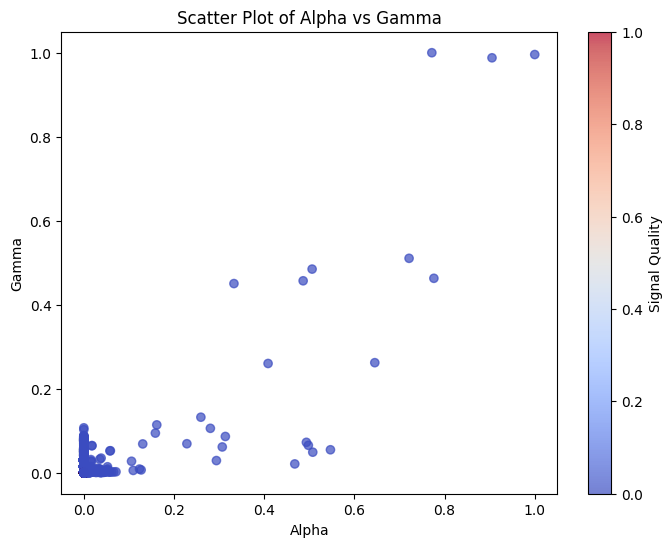

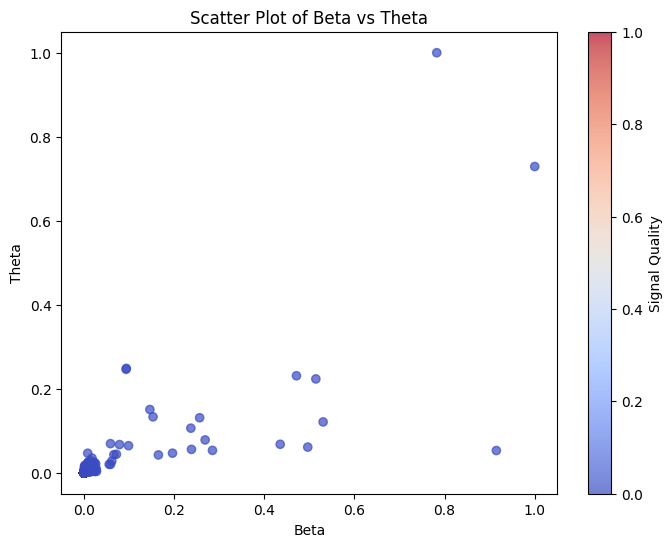

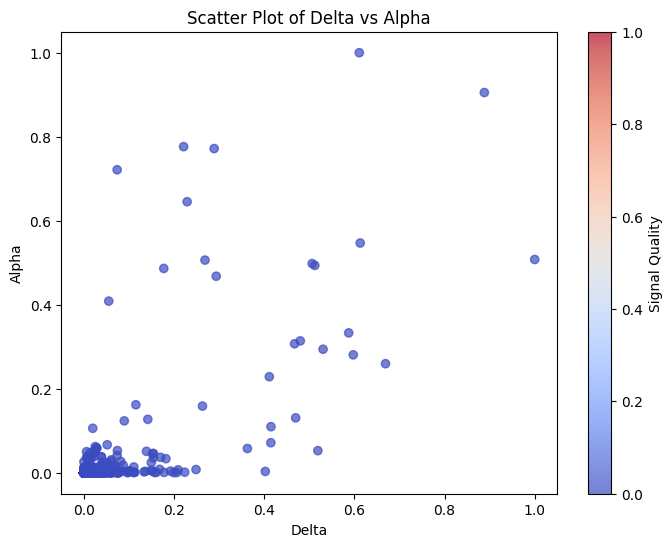

In [66]:
import matplotlib.pyplot as plt

# Define the pairs of bands to plot
band_pairs = [('alpha', 'gamma'), ('beta', 'theta'), ('delta', 'alpha')]

# Iterate over each pair and create scatter plots
for band1, band2 in band_pairs:
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train_normalized[band1], X_train_normalized[band2], c=y, cmap="coolwarm", alpha=0.7)
    plt.xlabel(band1.capitalize())
    plt.ylabel(band2.capitalize())
    plt.title(f'Scatter Plot of {band1.capitalize()} vs {band2.capitalize()}')
    plt.colorbar(label='Signal Quality')
    plt.show()

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize the KNeighborsClassifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Separate features and target
X_train = training_data.drop("target", axis=1)
y_train = training_data['target']

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_knn = grid_search.best_estimator_

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

Best parameters found: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Best cross-validation accuracy: 0.8280949743080361


We can now evaluate the cohen kappa

In [28]:
from sklearn.metrics import cohen_kappa_score, f1_score

# Separate features and target for validation set
# Extract some random pieces from X_train for validation
val_set = training_data.sample(frac=0.2, random_state=42)
X_val = val_set[['amplitude', 'snr']]
y_val = val_set['target']

# Make predictions using the best KNN model
predictions = best_knn.predict(X_val)

# Calculate and print the Cohen's kappa score and F1 score
print(cohen_kappa_score(predictions, y_val))
print(f1_score(y_val, predictions))

0.6984315281489474
0.8788904140198551


- What do you think of the performances ?
- What do you think of the split strategy ?
- What are additional features you could use ?

## Running the model on the test data and submitting to the leaderboard


In [29]:
ROOT_TEST_PATH = Path("test/")
test_data = {i:np.load(ROOT_TEST_PATH / f"data_{i}.npy") for i in [4,5]}
# We process each record independantly

def compute_features_on_record(data):
    """
    We compute each of the feature for each window and each channel
    Each value of the output dict has shape (Channels,T)
    """
    filtered_data =  butter_bandpass_filter(data,0.1,18,250,4)
    reshaped_data = reshape_array_into_windows(filtered_data,250,2)
    # Feature 1: Amplitude
    amplitude = (np.max(reshaped_data,-1) - np.min(reshaped_data,-1))
    print("Amplitude shape: ", amplitude.shape)
    # Feature 2: SNR
    snr_values = []
    for channel in range(reshaped_data.shape[0]):
        channel_snr = []
        for window in range(reshaped_data.shape[1]):
            snr = calculate_snr(reshaped_data[channel, window])
            channel_snr.append(snr)
        snr_values.append(channel_snr)
    snr_values = np.array(snr_values)
    print("SNR shape: ", snr_values.shape)
    return {"amplitude":amplitude,
            "snr":snr_values}

def compute_predictions_on_record(data,model,features_name_for_model):
    predictions = []
    features = compute_features_on_record(data)
    features = np.array([features[k] for k in features_name_for_model]) 
    features = features.swapaxes(0,1).swapaxes(1,2)
    for channel in range(features.shape[0]):
        predictions.append(model.predict(features[channel]))
    return np.array(predictions)

def format_array_to_target_format(array, record_number):
    assert isinstance(record_number, int)
    assert isinstance(array, np.ndarray)
    assert len(array.shape) == 2
    assert array.shape[0] == 5
    assert set(np.unique(array)) == {0, 1}
    formatted_target = []
    for i in range(array.shape[0]):
        channel_encoding = (i + 1) * 100000
        record_number_encoding = record_number * 1000000
        for j in range(array.shape[1]):
            formatted_target.append(
                {
                    "identifier": record_number_encoding + channel_encoding + j,
                    "target": array[i, j],
                }
            )
    return formatted_target
    


We the functions defined above, we can now run the model and submit the predictions

In [30]:
results = []
for record_number, data in test_data.items():
    preds = compute_predictions_on_record(data,best_knn,["amplitude", "snr"])
    formatted_preds = format_array_to_target_format(preds,record_number)
    results.extend(formatted_preds)
df = pd.DataFrame(results)
df.to_csv("submission.csv",index = False)

Amplitude shape:  (5, 13204)
SNR shape:  (5, 13204)


/Users/marioroca/eeg-signal-quality-analysis-by-beacon-biosignals/challenge/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/marioroca/eeg-signal-quality-analysis-by-beacon-biosignals/challenge/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/marioroca/eeg-signal-quality-analysis-by-beacon-biosignals/challenge/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/marioroca/eeg-signal-quality-analysis-by-beacon-biosignals/challenge/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/m

Amplitude shape:  (5, 9319)
SNR shape:  (5, 9319)


/Users/marioroca/eeg-signal-quality-analysis-by-beacon-biosignals/challenge/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/marioroca/eeg-signal-quality-analysis-by-beacon-biosignals/challenge/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/marioroca/eeg-signal-quality-analysis-by-beacon-biosignals/challenge/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/marioroca/eeg-signal-quality-analysis-by-beacon-biosignals/challenge/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/m

In [31]:
submission_df = pd.read_csv("submission.csv")
print(submission_df.head())

   identifier  target
0     4100000       0
1     4100001       0
2     4100002       0
3     4100003       0
4     4100004       0
